In [4]:
import numpy as np
from scipy.cluster.hierarchy import linkage,fcluster
import pickle
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import MapClass


In [902]:
def method2(semantic_map,feature_num,distance_type,n_clusters,merge_method="ward"):
    print("Calculating Distances")
    distances, valid_masks = generate_distance_matrix_subspace(semantic_map,feature_num,distance_type)
    print(distances)
    print("Clustering...")
    linked = linkage(distances, method=merge_method)
    clusters = fcluster(linked, t=n_clusters, criterion='maxclust')
    print("Done!")
    return clusters, valid_masks

def generate_distance_matrix_subspace(semantic_map,k,distance_type="projection"):
    mask_ids = []
    subspaces = []
    for img_id, local_masks in semantic_map.refined_prediction_masks.items():
        for mask_id in local_masks.keys():
            _,valid_indices = semantic_map.get_valid_keypoints(img_id,mask_id)
            try:
                score = semantic_map.gt_pred_correspondences[img_id][mask_id][1]
            except:
                continue
            if score < 0.5:
                continue
            data_points = semantic_map.descriptors[img_id][valid_indices].copy()
            if data_points.shape[0] < k:
                continue
            subspaces.append(get_subspace(data_points.T,k))
            mask_ids.append((img_id,mask_id))
    distances = np.zeros((len(subspaces), len(subspaces)))

    # Compute the pairwise distances only for the upper triangle (including diagonal)
    for i in range(len(subspaces)):
        for j in range(i, len(subspaces)):  # j starts from i to avoid redundant calculations
            if distance_type == "projection":
                dist = projection_distance(subspaces[i], subspaces[j])
            elif distance_type == "chordal_distance":
                dist = chordal_distance(subspaces[i], subspaces[j])
            if i == j:
                dist = 0
            distances[i, j] = dist
            distances[j, i] = dist
    return distances, mask_ids

def get_subspace(M,k):
    """
    Computes a k-dimensional orthonormal basis for the subspace spanned by the columns of M
    using Singular Value Decomposition (SVD).

    The function first centers the data in M by subtracting the mean of each row (feature),
    then performs SVD to identify the top-k principal components (left singular vectors),
    which form an orthonormal basis for the desired k-dimensional subspace.

    Parameters:
    ----------
    M : np.ndarray
        A 2D NumPy array of shape (d, n), where d is the dimensionality of each data point
        and n is the number of data points.
    k : int
        The number of leading components to extract (i.e., the dimensionality of the subspace).

    Returns:
    -------
    np.ndarray
        A (d, k) NumPy array whose columns form an orthonormal basis for the k-dimensional subspace.
    """

    M = M - np.mean(M, axis=1, keepdims=True)  # zero-mean across points
    # Perform SVD
    U, _, _ = np.linalg.svd(M, full_matrices=False)
    # Take the top-k left singular vectors => basis for k-dimensional subspace
    return U[:, :k]

def projection_distance(U, V):
    """
    Computes the projection (or subspace) distance between two subspaces represented by orthonormal bases U and V.

    The distance is defined as the Frobenius norm of the difference between the projection matrices of the subspaces.
    This measure is invariant to the choice of basis and reflects how different the two subspaces are.

    Parameters:
    ----------
    U : np.ndarray
        A (d, k1) matrix whose columns form an orthonormal basis for a k1-dimensional subspace in R^d.
    V : np.ndarray
        A (d, k2) matrix whose columns form an orthonormal basis for a k2-dimensional subspace in R^d.

    Returns:
    -------
    float
        The Frobenius norm of the difference between the projection matrices of U and V.
    """
    P_U = U @ U.T
    P_V = V @ V.T
    return np.linalg.norm(P_U - P_V, 'fro')

def chordal_distance(U, V):
    """
    Computes the chordal distance between two subspaces represented by orthonormal bases U and V.

    The chordal distance is based on the principal angles between subspaces, and is defined as
    the square root of the sum of the squared sine values of those angles. It provides a measure 
    of similarity between subspaces, with a value of 0 indicating identical subspaces.

    Parameters:
    ----------
    U : np.ndarray
        A (d, k1) matrix with orthonormal columns representing a k1-dimensional subspace in R^d.
    V : np.ndarray
        A (d, k2) matrix with orthonormal columns representing a k2-dimensional subspace in R^d.

    Returns:
    -------
    float
        The chordal distance between the two subspaces.
    """
    M = U.T @ V
    # Use numpy.linalg.svd
    sigma = np.linalg.svd(M, compute_uv=False)
    sin_squared = 1 - sigma**2
    return np.sqrt(np.sum(sin_squared))

In [559]:
with open('../../temp/clean.pkl','rb') as f:
    semantic_map = pickle.load(f)
object_dict = semantic_map.group_by_matched_label()
sorted_object_dict = dict(sorted(object_dict.items()))

In [1151]:
target = (0, 0)

# Find keys where the target tuple is in the value list
matching_keys = [k for k, v in sorted_object_dict.items() if target in v]
print(sorted_object_dict[matching_keys[0]])

[(0, 0), (5, 0), (7, 0), (8, 0), (9, 2), (10, 0), (11, 1), (12, 2), (13, 2), (14, 0), (19, 2), (20, 1), (25, 2), (26, 3), (27, 2), (28, 1), (29, 2), (30, 10), (31, 0), (36, 2), (37, 1), (38, 1), (39, 2), (40, 2), (41, 0), (42, 6), (53, 1), (54, 1), (55, 1), (56, 1), (70, 0), (71, 0), (72, 0), (73, 0)]


In [1222]:
distances, valid_masks = generate_distance_matrix_subspace(semantic_map, 15, "projection")
print(len(valid_masks))

549


In [1168]:
correct_counter = 0
false_counter = 0
object_list = []
for index0, item0 in enumerate(valid_masks):
    cost = distances[index0,:]
    non_zero_mean = cost[cost != 0].mean()
    cost[cost == 0] = non_zero_mean
    anomalies = z_score_anomaly(cost)
    if anomalies.shape[0]>0:
        for anomaly in anomalies:
            target = valid_masks[index0]
            matching_keys = [k for k, v in sorted_object_dict.items() if target in v]
            object_list.append((target,valid_masks[anomaly]))
            if valid_masks[anomaly] in sorted_object_dict[matching_keys[0]]:
                # print(f"Correct match found between {target} and {valid_masks[anomaly]}")
                correct_counter += 1
            else:
                print(f"False match at {target} and {valid_masks[anomaly]}")
                false_counter += 1

print(correct_counter)
print(false_counter)    


    

False match at (0, 2) and (44, 0)
False match at (0, 2) and (45, 1)
False match at (1, 5) and (23, 4)
False match at (2, 1) and (19, 4)
False match at (2, 1) and (25, 5)
False match at (2, 1) and (54, 3)
False match at (3, 1) and (54, 3)
False match at (4, 3) and (30, 1)
False match at (4, 3) and (42, 8)
False match at (5, 1) and (45, 1)
False match at (6, 0) and (11, 5)
False match at (6, 0) and (40, 0)
False match at (6, 0) and (46, 1)
False match at (6, 2) and (42, 8)
False match at (7, 1) and (45, 1)
False match at (10, 1) and (45, 1)
False match at (12, 4) and (25, 8)
False match at (17, 0) and (52, 0)
False match at (17, 0) and (69, 0)
False match at (17, 2) and (46, 1)
False match at (17, 2) and (61, 3)
False match at (22, 0) and (52, 0)
False match at (23, 0) and (51, 1)
False match at (23, 0) and (52, 0)
False match at (23, 4) and (26, 6)
False match at (23, 4) and (27, 6)
False match at (23, 10) and (52, 6)
False match at (24, 1) and (50, 1)
False match at (24, 1) and (51, 1)

In [1227]:
linked = linkage(distances, method="average")

C:\Users\Afiyet Olsun\AppData\Local\Temp\ipykernel_6368\2833526760.py:1: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(distances, method="average")


In [1112]:
clusters = fcluster(linked, t=4, criterion='distance')
len(np.unique(clusters))

79

0.761384335154827


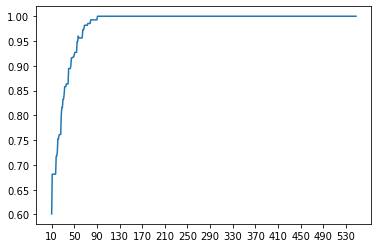

In [1228]:
percent_succeses = []
percent_ignores = []
for num in range(10,549):
    clusters = fcluster(linked, t=num, criterion='maxclust')

    single_instances = 0
    true_instances = 0
    all_instances = len(np.unique(clusters))
    for label in np.unique(clusters):
        # Get the indices for the current cluster
        indices = np.where(clusters == label)[0]  # Extract the array from the tuple
        if len(indices)==1:
            single_instances += 1
            continue
        object_labels = [semantic_map.gt_pred_correspondences[valid_masks[idx][0]][valid_masks[idx][1]][0] for idx in indices]
        all_equal = len(set(object_labels)) == 1
        if all_equal:
            true_instances += len(object_labels)
        else:
            object_names = [semantic_map.instance_id_to_name[obj_label] for obj_label in object_labels]
         
            if len(set(object_names)) == 1:
                true_instances += len(object_labels)
            
            else:
                counter = Counter(object_names)
                # Find the most common string
                most_common = counter.most_common(1)[0]  # Returns a tuple: (element, count)
                if 1-(most_common[1]/len(object_names)) < 0.2:
                    true_instances += most_common[1]
           

    percent_succeses.append((single_instances+true_instances)/len(valid_masks))
    percent_ignores.append(single_instances/len(valid_masks))
print(percent_succeses[15])
import matplotlib.pyplot as plt
plt.plot(range(10,549),percent_succeses)
plt.xticks(range(10,540,40))
# plt.plot(range(20,150),percent_ignores)
plt.show()

In [1260]:
np.argmax(percent_succeses),np.max(percent_succeses)

(81, 1.0)

In [637]:
percent_ignores[117]*549

14.000000000000002

In [1264]:
clusters = fcluster(linked, t=92, criterion='maxclust')

In [1265]:
pred_dict = {}
for object_label, masks_list in sorted_object_dict.items():
    for masks in masks_list:
        if masks in valid_masks:
            index = valid_masks.index(masks)
            if object_label not in pred_dict:
                pred_dict[object_label] = []
            pred_dict[object_label].append(clusters[index])
print(f"The number of objects to find after filter is {len(pred_dict)}")

The number of objects to find after filter is 32


In [1266]:
pred_dict = {}
for label in np.unique(clusters):
    # Get the indices for the current cluster
    indices = np.where(clusters == label)[0]  # Extract the array from the tuple
    object_labels = [semantic_map.gt_pred_correspondences[valid_masks[idx][0]][valid_masks[idx][1]][0] for idx in indices]
    object_names = [semantic_map.instance_id_to_name[obj_label] for obj_label in object_labels]
    pred_dict[label] = object_labels

In [640]:
unique_items = []
for label, gt_list in pred_dict.items():
    for gt_item in gt_list:
        if gt_item not in unique_items:
            unique_items.append(gt_item)
print(len(unique_items))

32


In [534]:
unique_items

['door',
 'couch',
 'Unknown',
 'wardrobe',
 'tv',
 'bed',
 'armchair',
 'nightstand',
 'bicycle',
 'table',
 'chandelier',
 'chair',
 'computer desk',
 'light',
 'blanket',
 'balustrade',
 'curtain',
 'cabinet',
 'ventilation',
 'picture']

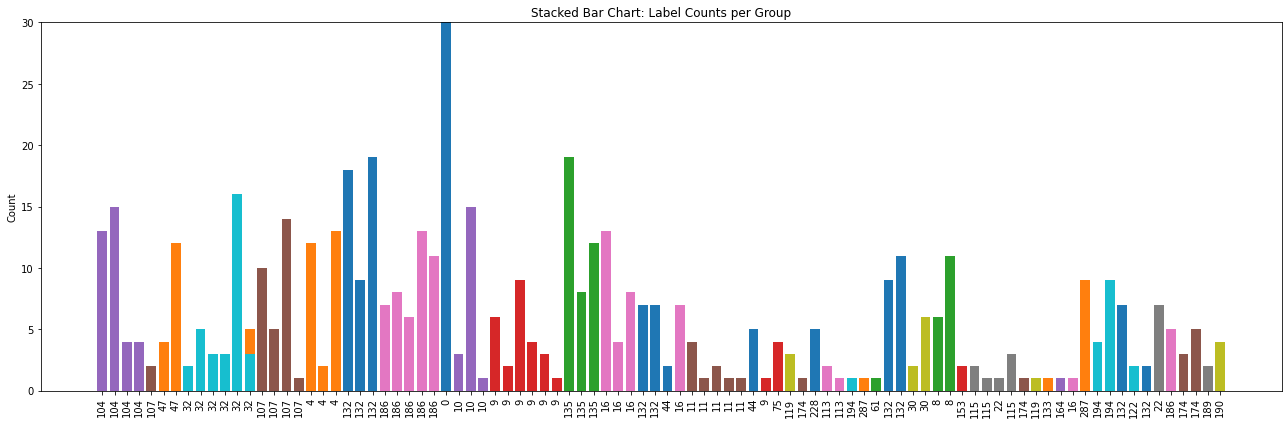

In [1267]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Sample dictionary
data = pred_dict

# Get all unique labels
all_labels = sorted(set(label for values in data.values() for label in values))
groups = list(data.keys())

# Count label occurrences per group
count_data = {group: Counter(values) for group, values in data.items()}
xlabels = [item.most_common(1)[0][0] for item in count_data.values()]

# Prepare for stacked bar plot
bottom = np.zeros(len(groups))  # start from 0
x = np.arange(len(groups))

fig, ax = plt.subplots(figsize=(18, 6))

# Plot each label as a stack
for label in all_labels:
    values = [count_data[group][label] for group in groups]
    ax.bar(x, values, bottom=bottom, label=label)
    bottom += values  # update for stacking

# Format plot
ax.set_xticks(x)
for label in ax.get_xticklabels():
    label.set_rotation(90)
ax.set_xticklabels(xlabels)
ax.set_ylabel("Count")
ax.set_title("Stacked Bar Chart: Label Counts per Group")
plt.tight_layout()
plt.show()

[104, 104, 104, 107, 47, 32, 32, 107, 4, 4, 132, 132, 186, 186, 0, 10, 9, 9, 135, 16, 16, 132, 16, 11, 44, 9, 75, 119, 228, 113, 61, 132, 30, 8, 115, 287, 194, 132, 22, 174]


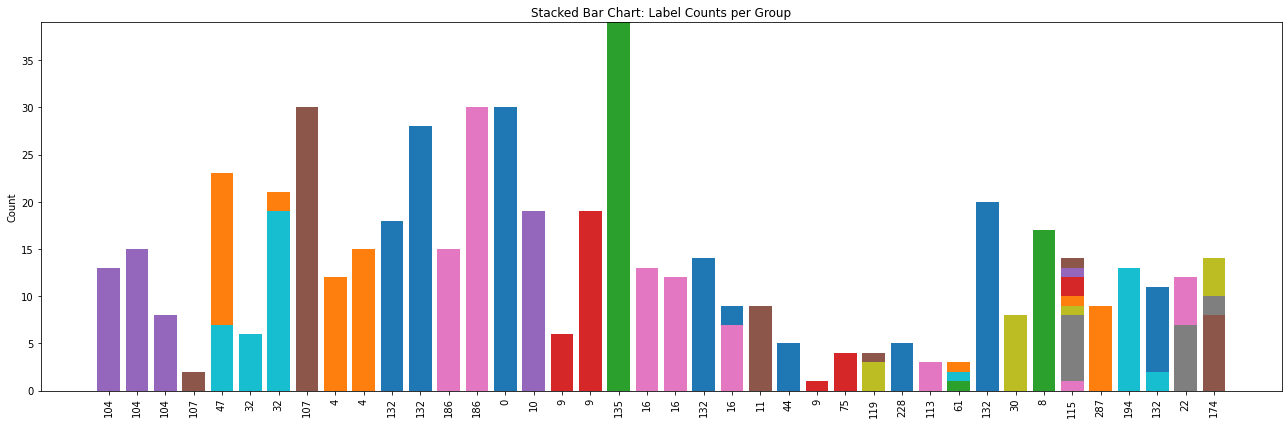

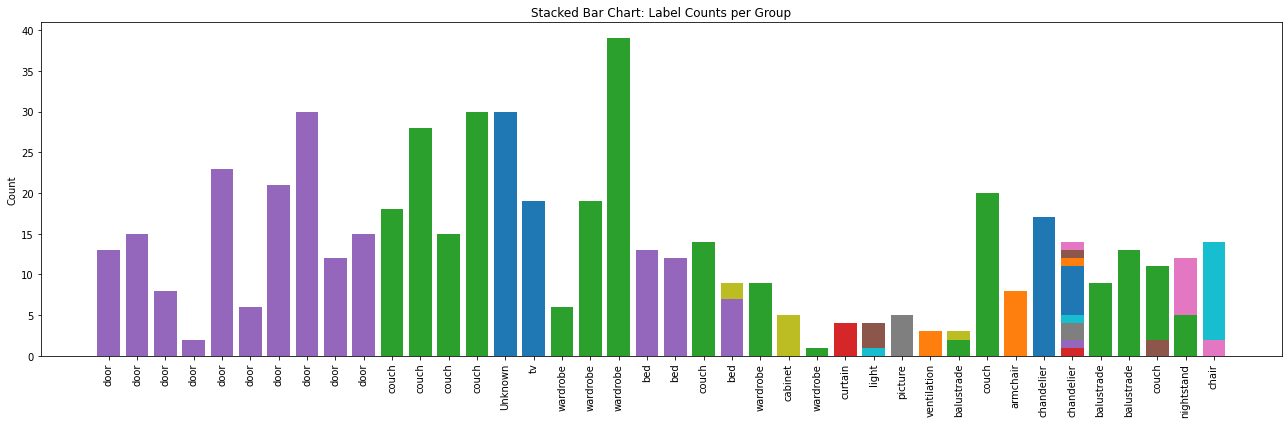

In [662]:
for u, v, attrs in semantic_map.G.edges(data=True):
    matches = attrs['matches'].cpu().numpy()
    print(matches[:, 0])
    break

[ 21  24  28  41  56  63  67  74  75  99 107 112 115 130 133 147 157 158
 163 164 167 170 173 177 178 180 182 184 185 186 188 189 191 197 198 199
 200 201 202 203 205 206 207 209 210 214 217 218 219 220 221 225 226 227
 229 230 233 236 237 243 244 245 246 250 251 253 254 256 257 258 262 264
 265 267 269 271 272 273 274 275 277 279 280 285 286 289 291 292 297 301
 304 306 308 310 314 316 318 319 320 322 323 324 325 326 327 329 330 332
 333 335 337 338 339 340 341 342 343 346 350 351 352 354 356 357 360 361
 362 363 364 366 368 372 374 378 379 380 381 382 384 385 386 387 388 390
 391 393 395 399 400 402 403 404 405 407 410 411 413 415 418 420 421 422
 423 426 430 431 432 433 434 435 436 438 439 441 443 444 445 449 450 452
 453 454 457 459 460 461 463 465 466 469 470 471 472 474 478 483 485 486
 488 489 491 493 496 501 502 503 504 509 510 513 514 515 516 519 521 522
 523 524 526 536 537 539 544 545 546 548 549 550 551 552 553 554 556 557
 559 562 563 564 566 568 572 573 576 577 581 582 58

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from collections import Counter
import numpy as np

# Sample data
data = pred_dict

# Unique labels and groups
all_labels = sorted(set(label for v in data.values() for label in v))
groups = list(data.keys())

# Count items per group
count_data = {group: Counter(values) for group, values in data.items()}

# Set up the color map
color_map = cm.get_cmap('tab10', len(all_labels))  # or 'Set3', 'Paired', etc.
label_colors = {label: color_map(i) for i, label in enumerate(all_labels)}

# Plot
x = np.arange(len(groups))
bottom = np.zeros(len(groups))

fig, ax = plt.subplots(figsize=(18, 6))

for label in all_labels:
    values = [count_data[group][label] for group in groups]
    ax.bar(x, values, bottom=bottom, label=label, color=label_colors[label])
    bottom += values

# Format plot
ax.set_xticks(x)
ax.set_xticklabels(groups)
ax.set_ylabel("Count")
ax.set_title("Stacked Bar Chart: Label Counts per Group")
plt.tight_layout()
plt.show()


In [569]:
for gt_label, list_cluster in pred_dict.items():
    print(f"Object {semantic_map.instance_id_to_name[gt_label]} have {len(list_cluster)} instances.")
    print(f"The instances are grouped under {len(set(list_cluster))} clusters")
    if len(set(list_cluster)) > 1:
        counter = Counter(list_cluster)
        most_common = counter.most_common(1)[0]
        print(f"{most_common[1]} of them are in cluster {most_common[0]}")
        

    print('\n')

    

Object Unknown have 18 instances.
The instances are grouped under 1 clusters


Object door have 26 instances.
The instances are grouped under 2 clusters
14 of them are in cluster 7


Object chandelier have 11 instances.
The instances are grouped under 1 clusters


Object wardrobe have 24 instances.
The instances are grouped under 2 clusters
18 of them are in cluster 17


Object tv have 17 instances.
The instances are grouped under 1 clusters


Object wardrobe have 4 instances.
The instances are grouped under 1 clusters


Object bed have 31 instances.
The instances are grouped under 4 clusters
11 of them are in cluster 25


Object nightstand have 5 instances.
The instances are grouped under 1 clusters


Object armchair have 4 instances.
The instances are grouped under 1 clusters


Object door have 28 instances.
The instances are grouped under 3 clusters
19 of them are in cluster 5


Object cabinet have 3 instances.
The instances are grouped under 1 clusters


Object door have 15 instanc

22 37
0.5675675675675675
25 29
0.5862068965517242
23 30
0.7
26 29
0.5862068965517242
23 30
0.7
27 22
0.7727272727272727
24 30
0.7
28 22
0.7727272727272727
25 30
0.7
29 22
0.7727272727272727
25 30
0.7
29 12
0.5833333333333333
30 10
0.5
26 30
0.7
30 12
0.5833333333333333
31 10
0.5
27 30
0.7
31 12
0.5833333333333333
32 10
0.5
28 30
0.7
32 12
0.5833333333333333
33 10
0.5
28 15
0.4
29 15
0.6666666666666667
33 12
0.5833333333333333
34 10
0.5
29 15
0.4
30 15
0.6666666666666667
34 12
0.5833333333333333
35 10
0.5
30 15
0.4
31 15
0.6666666666666667
35 12
0.5833333333333333
36 10
0.5
31 15
0.4
32 15
0.6666666666666667
36 12
0.5833333333333333
37 10
0.5
31 15
0.4
32 15
0.6666666666666667
36 12
0.5833333333333333
37 10
0.5
32 15
0.4
33 15
0.6666666666666667
37 12
0.5833333333333333
38 10
0.5
32 15
0.4
34 11
0.5454545454545454
38 12
0.5833333333333333
39 10
0.5
32 15
0.4
34 11
0.5454545454545454
38 12
0.5833333333333333
39 5
0.4
33 15
0.4
35 11
0.5454545454545454
39 12
0.5833333333333333
40 5
0.4
34

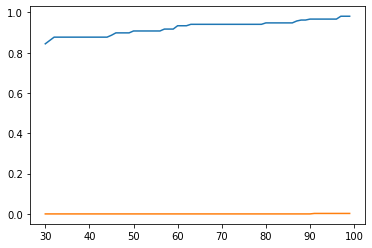

In [484]:
percent_succeses[0]

0.848816029143898

In [308]:
range(50,150)[np.argmax(percent_succeses)]

147

In [231]:
percent_succeses[7],range(20,50,2)[7]

(0.8529411764705882, 34)

In [587]:
for label in np.unique(clusters):

    output_folder = f"./outputs/{label}"
    if not os.path.exists(output_folder):
        os.mkdir(output_folder)

    indices = np.where(clusters == label)[0]
    for idx in indices:        
        img_id,mask_id = valid_masks[idx]
        rgb_img = semantic_map.rgb_observations[img_id].copy()
        mask = semantic_map.refined_prediction_masks[img_id][mask_id]
        kernel = np.ones((3, 3), np.uint8)
        dilated_mask = cv2.dilate(mask,kernel,iterations=1)
        edges = dilated_mask - mask
        rgb_img[edges==1] = [255,0,0]
        res = cv2.cvtColor(rgb_img,cv2.COLOR_RGB2BGR)
        image_path = os.path.join(output_folder,f"{img_id}_{mask_id}_{semantic_map.gt_pred_correspondences[img_id][mask_id][0]}.png")
        cv2.imwrite(image_path,res)
    
    
    

In [ ]:
clusters = fcluster(linked, t=150, criterion='maxclust')

single_instances = 0
true_instances = 0
all_instances = len(np.unique(clusters))
for label in np.unique(clusters):
    # Get the indices for the current cluster
    indices = np.where(clusters == label)[0]  # Extract the array from the tuple
    if len(indices)==1:
        single_instances += 1
        continue
    object_labels = [semantic_map.gt_pred_correspondences[valid_masks[idx][0]][valid_masks[idx][1]][0] for idx in indices]
    all_equal = len(set(object_labels)) == 1
    if all_equal:
        true_instances += 1
    else:
        print(object_labels)
        print([valid_masks[idx] for idx in indices])
percent_succeses.append((true_instances+single_instances)/all_instances)
percent_ignores.append(single_instances/all_instances)

[174, 174, 164]
[(133, 14), (134, 21), (141, 0)]
[61, 287]
[(6, 0), (88, 11)]
[194, 115]
[(82, 1), (104, 5)]
[115, 133, 115, 115]
[(107, 11), (110, 4), (115, 4), (129, 4)]
[22, 16]
[(0, 0), (1, 5)]


In [28]:
semantic_map.gt_pred_correspondences[141][0]

(164, 0.5797629899726527)

In [33]:
semantic_map.instance_id_to_name[174]

'chair'

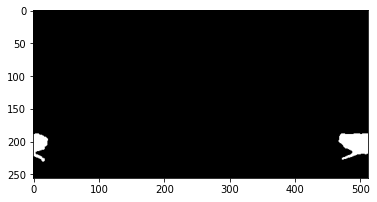

In [45]:
plt.imshow(semantic_map.refined_prediction_masks[133][14],cmap="gray")
plt.show()

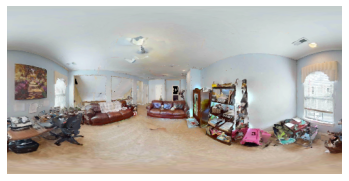

In [46]:
semantic_map.display_rgb_observation(141)

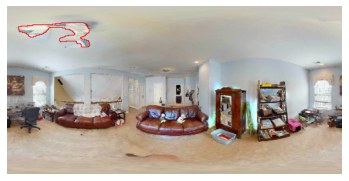

In [55]:
img_id, mask_id  = 115, 4
rgb_img = semantic_map.rgb_observations[img_id].copy()
mask = semantic_map.refined_prediction_masks[img_id][mask_id]
kernel = np.ones((3, 3), np.uint8)
dilated_mask = cv2.dilate(mask,kernel,iterations=1)
edges = dilated_mask - mask
rgb_img[edges==1] = [255,0,0]
plt.imshow(rgb_img)
plt.axis("off")
plt.show()

In [72]:
type(clusters)

numpy.ndarray

In [124]:
def generate_distance_matrix_subspace_v2(semantic_map,k,valid_masks,clusters,distance_type="projection"):
    mask_ids = []
    subspaces = []
    for i in range(1,len(np.unique(clusters))+1):
        indices = np.where(clusters==i)[0]
        data_points = np.empty((0, 256))
        temp_mask_ids = []
        for index in indices:
            img_id, mask_id = valid_masks[index]
            _,valid_indices = semantic_map.get_valid_keypoints(img_id,mask_id)
            data_points = np.vstack([data_points,semantic_map.descriptors[img_id][valid_indices].copy()])
            temp_mask_ids.append((img_id,mask_id))

        if data_points.shape[0] >= k: 
            subspaces.append(get_subspace(data_points.T,k))
            mask_ids.append(temp_mask_ids)
        
    distances = np.zeros((len(subspaces), len(subspaces)))

    # Compute the pairwise distances only for the upper triangle (including diagonal)
    for i in range(len(subspaces)):
        for j in range(i, len(subspaces)):  # j starts from i to avoid redundant calculations
            if distance_type == "projection":
                dist = projection_distance(subspaces[i], subspaces[j])
            elif distance_type == "chordal_distance":
                dist = chordal_distance(subspaces[i], subspaces[j])
            distances[i, j] = dist
            distances[j, i] = dist
    return distances, mask_ids

In [419]:
distances2, valid_masks2 = generate_distance_matrix_subspace_v2(semantic_map,20,valid_masks,clusters)

In [420]:
counter = 0
for i in valid_masks2:
    counter += len(i)
print(counter)

524


In [ ]:
linked2 = linkage(distances2, method="ward")


C:\Users\Afiyet Olsun\AppData\Local\Temp\ipykernel_6368\3559114569.py:1: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked2 = linkage(distances2, method="ward")


In [425]:
clusters2 = fcluster(linked2, t=5.8, criterion='distance')
len(np.unique(clusters2))

110

In [383]:
for label in np.unique(loop_clusters):

    output_folder = f"./outputs/{label}"
    if not os.path.exists(output_folder):
        os.mkdir(output_folder)

    indices = np.where(loop_clusters == label)[0]
    for idx in indices: 
        masks = loop_valid_masks[idx]       
        for img_id,mask_id in masks: 
            rgb_img = semantic_map.rgb_observations[img_id].copy()
            mask = semantic_map.refined_prediction_masks[img_id][mask_id]
            kernel = np.ones((3, 3), np.uint8)
            dilated_mask = cv2.dilate(mask,kernel,iterations=1)
            edges = dilated_mask - mask
            rgb_img[edges==1] = [255,0,0]
            res = cv2.cvtColor(rgb_img,cv2.COLOR_RGB2BGR)
            image_path = os.path.join(output_folder,f"{img_id}_{mask_id}.png")
            cv2.imwrite(image_path,res)

In [ ]:
for label in np.unique(clusters2):
    object_labels = [semantic_map.gt_pred_correspondences[img_id][mask_id][0] for idx in indices for img_id, mask_id in valid_masks2[idx]]
        all_equal = len(set(object_labels)) == 1
        if all_equal:
            true_instances += 1

177

In [398]:
counter = 0
for i in valid_masks2:
    counter += len(i)
print(counter)

549


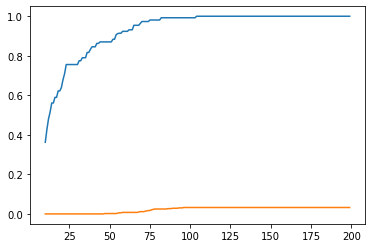

In [422]:
percent_succeses2 = []
percent_ignores2 = []
for num in range(10,200):
    clusters2 = fcluster(linked2, t=num, criterion='maxclust')
    single_instances = 0
    true_instances = 0
    all_instances = len(np.unique(clusters2))
    for label in np.unique(clusters2):
        # Get the indices for the current cluster
        indices = np.where(clusters2 == label)[0]  # Extract the array from the tuple
        corresponding_masks = [item for idx in indices for item in valid_masks2[idx]]
        if len(corresponding_masks)==1:
            single_instances += 1
            continue
        object_labels = [semantic_map.gt_pred_correspondences[img_id][mask_id][0] for img_id, mask_id in corresponding_masks]
        all_equal = len(set(object_labels)) == 1
        if all_equal:
            true_instances += len(corresponding_masks)
    percent_succeses2.append((single_instances+true_instances)/counter)
    percent_ignores2.append(single_instances/counter)
    
plt.plot(range(10,200),percent_succeses2)
plt.plot(range(10,200),percent_ignores2)
plt.show()

In [442]:
np.argmax(percent_succeses2)

94

In [305]:
range(10,140)[np.argmax(percent_succeses2)]

104

In [296]:
def generate_distance_matrix_subspace_v3(semantic_map,k,valid_masks,clusters,distance_type="projection"):
    mask_ids = []
    subspaces = []
    for i in range(1,len(np.unique(clusters))+1):
        indices = np.where(clusters==i)[0]
        data_points = np.empty((0, 256))
        temp_mask_ids = []
        for index in indices:
            masks = valid_masks[index]
            for img_id, mask_id in masks:  
                _,valid_indices = semantic_map.get_valid_keypoints(img_id,mask_id)
                data_points = np.vstack([data_points,semantic_map.descriptors[img_id][valid_indices].copy()])
                temp_mask_ids.append((img_id,mask_id))

        if data_points.shape[0] >= k: 
            subspaces.append(get_subspace(data_points.T,k))
            mask_ids.append(temp_mask_ids)
        
    distances = np.zeros((len(subspaces), len(subspaces)))

    # Compute the pairwise distances only for the upper triangle (including diagonal)
    for i in range(len(subspaces)):
        for j in range(i, len(subspaces)):  # j starts from i to avoid redundant calculations
            if distance_type == "projection":
                dist = projection_distance(subspaces[i], subspaces[j])
            elif distance_type == "chordal_distance":
                dist = chordal_distance(subspaces[i], subspaces[j])
            distances[i, j] = dist
            distances[j, i] = dist
    return distances, mask_ids

In [359]:
distances3, valid_masks3 = generate_distance_matrix_subspace_v3(semantic_map,20,valid_masks2,clusters2)

In [426]:
loop_valid_masks = valid_masks2
loop_clusters = clusters2
for i in range(6):
    print(len(np.unique(loop_clusters)))
    loop_distance, loop_valid_masks = generate_distance_matrix_subspace_v3(semantic_map,20,loop_valid_masks,loop_clusters)
    loop_linked = linkage(loop_distance, method="ward")
    loop_clusters = fcluster(loop_linked, t=5.5, criterion='distance')
    
    

110


C:\Users\Afiyet Olsun\AppData\Local\Temp\ipykernel_6368\653546340.py:6: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  loop_linked = linkage(loop_distance, method="ward")


89
81
79
77
77


In [ ]:
loop_clusters = fcluster(loop_linked, t=5.7, criterion='distance')
len(np.unique(loop_clusters))

33

In [ ]:
linked3 = linkage(distances3, method="ward")
clusters3 = fcluster(linked3, t=6, criterion='distance')
len(np.unique(clusters3))

C:\Users\Afiyet Olsun\AppData\Local\Temp\ipykernel_6368\1532867529.py:1: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked3 = linkage(distances3, method="ward")


69

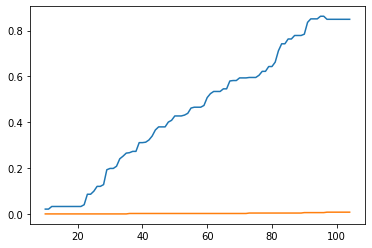

In [427]:
percent_succeses3 = []
percent_ignores3 = []
for num in range(10,105):
    clusters3 = fcluster(linked3, t=num, criterion='maxclust')
    single_instances = 0
    true_instances = 0
    all_instances = len(np.unique(clusters3))
    for label in np.unique(clusters3):
        # Get the indices for the current cluster
        indices = np.where(clusters3 == label)[0]  # Extract the array from the tuple
        corresponding_masks = [item for idx in indices for item in valid_masks2[idx]]
        if len(corresponding_masks)==1:
            single_instances += 1
            continue
        object_labels = [semantic_map.gt_pred_correspondences[img_id][mask_id][0] for idx in indices for img_id, mask_id in valid_masks3[idx]]
        all_equal = len(set(object_labels)) == 1
        if all_equal:
            true_instances += len(object_labels)
    percent_succeses3.append((single_instances + true_instances)/counter)
    percent_ignores3.append(single_instances/counter)
    
plt.plot(range(10,105),percent_succeses3)
plt.plot(range(10,105),percent_ignores3)

In [357]:
range(10,100)[np.where(np.array(percent_succeses3)>=0.9)[0][0]]

56

In [344]:
percent_succeses3[40]

0.9

In [ ]:
for i in valid_masks3:
    if len(i)<2:
        

[(77, 1)]
[(10, 9)]
[(27, 5)]
[(6, 0)]
[(76, 9)]
[(0, 10)]
[(1, 5)]
[(25, 8)]
[(19, 9)]
[(134, 21)]
[(0, 0)]
[(42, 4)]
[(129, 4)]
[(107, 11)]
[(115, 4)]
[(133, 14)]
[(114, 16)]


In [429]:
single_instances = 0
true_instances = 0
all_instances = len(np.unique(loop_clusters))
for label in np.unique(loop_clusters):
    # Get the indices for the current cluster
    indices = np.where(loop_clusters == label)[0]  # Extract the array from the tuple
    corresponding_masks = [item for idx in indices for item in loop_valid_masks[idx]]
    if len(corresponding_masks)==1:
        single_instances += 1
        continue
    object_labels = [semantic_map.gt_pred_correspondences[img_id][mask_id][0] for idx in indices for img_id, mask_id in loop_valid_masks[idx]]
    all_equal = len(set(object_labels)) == 1
    if all_equal:
        true_instances += len(object_labels)
(single_instances+true_instances)/counter

0.7099236641221374

In [678]:
def method3(semantic_map,min_num_feature):
    graph = semantic_map.G
    masks_with_keypoints = {}
    for img_id, val in semantic_map.refined_prediction_masks.items():
        if img_id not in masks_with_keypoints.keys():
            masks_with_keypoints[img_id] = {}
        for mask_id, mask in val.items():
            _,ids = semantic_map.get_valid_keypoints(img_id,mask_id)
            if len(ids) >= min_num_feature:
                masks_with_keypoints[img_id][mask_id]= {"mask":mask,"valid_keypoints":np.where(ids==1)[0]}
    for node0, node1, attrs in graph.edges(data=True):
        matches = attrs["matches"].cpu().numpy()
        lookup_table = {kpt: mask_id1 for mask_id1, mask_kpts1 in masks_with_keypoints[node1].items() for kpt in mask_kpts1["valid_keypoints"]}
        for mask_id0, mask_kpts0 in masks_with_keypoints[node0].items():
            mask0, valid_kps0 = mask_kpts0["mask"],mask_kpts0["valid_keypoints"]
            print(valid_kps0)
            # make a new list if element in valid_indices is in matches01[:, 0] without iterating
            valid_indices = np.intersect1d(valid_kps0, matches[:, 0])
            print(f"Valid indices{valid_indices}")
            # find the index of the valid_indices in matches01[:, 0]
            match_indices = np.where(np.isin(matches[:, 0], valid_indices))[0]
            corresponding_indices = matches[match_indices, 1].tolist()
            print(f"Corresponding indices{corresponding_indices}")

            corresponding_objects = [(mask_id0, lookup_table.get(kpts1, None)) for kpts1 in corresponding_indices
                            if lookup_table.get(kpts1, None) is not None]
            # find the corresponding objects in objects1 if key is not in lookup_table, skip it
            object_feature_pair = [((mask_id0, lookup_table.get(kpts1, None)),(kpts0,kpts1), ) for kpts0, kpts1 in zip(valid_indices, corresponding_indices)
                                    if lookup_table.get(kpts1, None) is not None]
            try:
                corresponding_objects, corresponding_features = zip(*object_feature_pair)
                # make them lists
                corresponding_objects, corresponding_features = list(corresponding_objects), list(corresponding_features)
            except ValueError:
                corresponding_objects, corresponding_features = [], []
            if corresponding_objects:
                # Find the count for each pair
                pair_count = Counter(corresponding_objects)

                # take the maximum count and the corresponding pair
                max_pair, max_count = pair_count.most_common(1)[0]
                print(node0, max_pair[0], node1, max_pair[1])

In [673]:
_,ids = semantic_map.get_valid_keypoints(img_id,mask_id)

array([  9,  12,  16,  17,  20,  27,  29,  31,  32,  33,  37,  40,  42,
        44,  45,  46,  49,  51,  52,  55,  57,  59,  61,  63,  64,  65,
        69,  71,  72,  73,  75,  90, 114], dtype=int64)

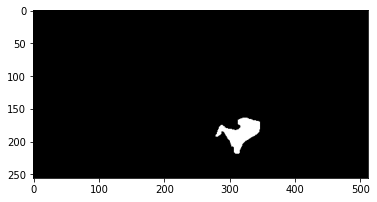

In [682]:
mask = semantic_map.refined_prediction_masks[5][0]
plt.imshow(mask,cmap="gray")
plt.show()

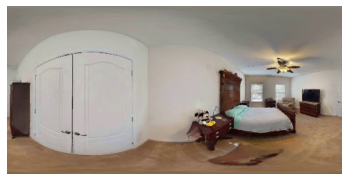

In [683]:
semantic_map.display_rgb_observation(5)

In [1275]:
def method3(semantic_map,min_num_feature):
    graph = semantic_map.G
    masks_with_keypoints = {}
    for img_id, val in semantic_map.refined_prediction_masks.items():
        if img_id not in masks_with_keypoints.keys():
            masks_with_keypoints[img_id] = {}
        for mask_id, mask in val.items():
            _,ids = semantic_map.get_valid_keypoints(img_id,mask_id)
            if len(np.where(ids==1)[0]) >= min_num_feature:
                masks_with_keypoints[img_id][mask_id]= {"mask":mask,"valid_keypoints":np.where(ids==1)[0]}
    object_list=[]
    for node0, node1, attrs in graph.edges(data=True):
        matches = attrs["matches"].cpu().numpy()
        lookup_table = {kpt: mask_id1 for mask_id1, mask_kpts1 in masks_with_keypoints[node1].items() for kpt in mask_kpts1["valid_keypoints"]}
        for mask_id0, mask_kpts0 in masks_with_keypoints[node0].items():
            mask0, valid_kps0 = mask_kpts0["mask"],mask_kpts0["valid_keypoints"]
            # make a new list if element in valid_indices is in matches01[:, 0] without iterating
            valid_indices = np.intersect1d(valid_kps0, matches[:, 0])
            # find the index of the valid_indices in matches01[:, 0]
            match_indices = np.where(np.isin(matches[:, 0], valid_indices))[0]
            corresponding_indices = matches[match_indices, 1].tolist()

            corresponding_objects = [(mask_id0, lookup_table.get(kpts1, None)) for kpts1 in corresponding_indices
                            if lookup_table.get(kpts1, None) is not None]
            # find the corresponding objects in objects1 if key is not in lookup_table, skip it
            object_feature_pair = [((mask_id0, lookup_table.get(kpts1, None)),(kpts0,kpts1), ) for kpts0, kpts1 in zip(valid_indices, corresponding_indices)
                                    if lookup_table.get(kpts1, None) is not None]
            try:
                corresponding_objects, corresponding_features = zip(*object_feature_pair)
                # make them lists
                corresponding_objects, corresponding_features = list(corresponding_objects), list(corresponding_features)
            except ValueError:
                corresponding_objects, corresponding_features = [], []
            if corresponding_objects:
                # Find the count for each pair
                pair_count = Counter(corresponding_objects)

                # take the maximum count and the corresponding pair
                max_pair, max_count = pair_count.most_common(1)[0]

                confidence = max_count / len(corresponding_objects)
                min_feat_count = min(len(masks_with_keypoints[node0][max_pair[0]]["valid_keypoints"]), len(masks_with_keypoints[node1][max_pair[1]]["valid_keypoints"]))
                avg_feat_count = (len(masks_with_keypoints[node0][max_pair[0]]["valid_keypoints"]) +len(masks_with_keypoints[node1][max_pair[1]]["valid_keypoints"])) / 2
                score = confidence * max_count**2 / (avg_feat_count * min_feat_count)
                if max_pair[0] == 0 and max_pair[1] == 0 and node0 == 0 and node1 == 5:
                    print(score)
                # pair_scores.append((max_pair, score))
                if score >= 0.3:
                    object_list.append((node0,max_pair[0],node1,max_pair[1]))

    return object_list

In [1276]:
object_matches = method3(semantic_map,15)

0.08384508310816342


In [1285]:
len(object_matches)

2322

In [711]:
from collections import defaultdict
class UnionFind:
    def __init__(self):
        self.parent = {}
        self.rank = {}

    def find(self, x):
        if self.parent[x] != x:
            self.parent[x] = self.find(self.parent[x])  # Path compression
        return self.parent[x]

    def union(self, x, y):
        rootX = self.find(x)
        rootY = self.find(y)

        if rootX != rootY:
            # Union by rank
            if self.rank[rootX] > self.rank[rootY]:
                self.parent[rootY] = rootX
            elif self.rank[rootX] < self.rank[rootY]:
                self.parent[rootX] = rootY
            else:
                self.parent[rootY] = rootX
                self.rank[rootX] += 1

    def add(self, x):
        if x not in self.parent:
            self.parent[x] = x
            self.rank[x] = 0

def find_connected_components(grouped_relations):
    uf = UnionFind()

    # Build the Union-Find structure and perform unions
    for group in grouped_relations:
        # Add all the tuples in the group to the Union-Find structure first
        for (a, b) in group:
            uf.add((a, b))  # Ensure both tuples are added to the structure
            
        # Now, union each pair in the group
        for i, (a, b) in enumerate(group):
            for j, (c, d) in enumerate(group):
                if (a, b) != (c, d):  # Avoid self-union
                    uf.union((a, b), (c, d))

    # Collect connected components
    components = defaultdict(list)  # Now this will work because defaultdict is imported
    for node in uf.parent:
        root = uf.find(node)
        components[root].append(node)

    return list(components.values())

In [1167]:
counter = 0
for item in short_gs2:
    counter += len(item)
print(counter)

544


In [1165]:
gs2 = find_connected_components(object_list)
short_gs2 = [g for g in gs2 if len(g) >= 3]
print(len(short_gs2))
for idx,labels in enumerate(short_gs2):
    output_folder = f"./outputs/{idx}"
    if not os.path.exists(output_folder):
        os.mkdir(output_folder)
    for img_id,mask_id in labels: 
        rgb_img = semantic_map.rgb_observations[img_id].copy()
        mask = semantic_map.refined_prediction_masks[img_id][mask_id]
        kernel = np.ones((3, 3), np.uint8)
        dilated_mask = cv2.dilate(mask,kernel,iterations=1)
        edges = dilated_mask - mask
        rgb_img[edges==1] = [255,0,0]
        res = cv2.cvtColor(rgb_img,cv2.COLOR_RGB2BGR)
        try:
            image_path = os.path.join(output_folder,f"{img_id}_{mask_id}_{semantic_map.gt_pred_correspondences[img_id][mask_id][0]}.png")
        except:
            image_path = os.path.join(output_folder,f"{img_id}_{mask_id}.png")
        cv2.imwrite(image_path,res)
    

13


In [1286]:
grouped_relations = [[(d[0],d[1]),(d[2],d[3])] for d in object_matches]
print(len(grouped_relations))
grouped_set = find_connected_components(grouped_relations)
print(len(grouped_set))


2322
41


In [ ]:
counter = 0
for i in grouped_set:
    counter += len(i)
print(counter)

498


In [1280]:
short_grouped_set = [g for g in grouped_set if len(g) >= 3]
print(len(short_grouped_set))

25


In [1297]:
from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    v_measure_score,
    homogeneity_score,
    completeness_score,
    fowlkes_mallows_score
)

# Example: ground truth and predicted cluster labels (with unequal counts)
true_labels =    gt_labels
predicted_labels = pred_labels

# Compute clustering metrics
print("Adjusted Rand Index (ARI):", adjusted_rand_score(true_labels, predicted_labels))
print("Normalized Mutual Information (NMI):", normalized_mutual_info_score(true_labels, predicted_labels))
print("Fowlkes-Mallows Score:", fowlkes_mallows_score(true_labels, predicted_labels))
print("Homogeneity:", homogeneity_score(true_labels, predicted_labels))
print("Completeness:", completeness_score(true_labels, predicted_labels))
print("V-Measure:", v_measure_score(true_labels, predicted_labels))

Adjusted Rand Index (ARI): 0.8966356029050628
Normalized Mutual Information (NMI): 0.9673561635104748
Fowlkes-Mallows Score: 0.9079743205473197
Homogeneity: 0.997623774276127
Completeness: 0.9388710917850224
V-Measure: 0.9673561635104748


In [1296]:
mask_count = 0
gt_labels = []
pred_labels = []
for idx,i in enumerate(short_grouped_set):
    for img_id, mask_id in i:
        try:
            gt_label = semantic_map.gt_pred_correspondences[img_id][mask_id][0]
            gt_labels.append(gt_label)
            pred_label = idx
            pred_labels.append(pred_label)
        except:
            continue
print(len(np.unique(pred_labels)))

25


In [ ]:
pred_labels, gt_labels

[22,
 22,
 22,
 22,
 22,
 22,
 22,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 44,
 44,
 44,
 44,
 44,
 32,
 32,
 32,
 32,
 32,
 35,
 32,
 32,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 132,
 132,
 132,
 132,
 107,
 107,
 107,
 107,

In [1288]:
final_labels = []
count_object_labels = []
for idx,labels in enumerate(short_grouped_set):
    object_labels = []
    for img_id,mask_id in labels:
        try:
            gt_label = semantic_map.gt_pred_correspondences[img_id][mask_id][0]
        except:
            continue
        object_labels.append(gt_label)
    if object_labels:
        counter = Counter(object_labels)
        most_common = counter.most_common(1)[0]
        final_labels.append((idx,most_common[0],most_common[1]/len(object_labels)))
        count_object_labels.append(most_common[0])
    else:
        print(idx)
    


In [ ]:
print("Homogeneity:", homogeneity_score(true_labels, predicted_labels))
print("Completeness:", completeness_score(true_labels, predicted_labels))

In [1289]:
final_labels

[(0, 22, 1.0),
 (1, 4, 1.0),
 (2, 16, 1.0),
 (3, 32, 1.0),
 (4, 8, 1.0),
 (5, 10, 1.0),
 (6, 47, 1.0),
 (7, 44, 1.0),
 (8, 32, 0.875),
 (9, 104, 1.0),
 (10, 30, 1.0),
 (11, 132, 1.0),
 (12, 107, 1.0),
 (13, 132, 1.0),
 (14, 9, 1.0),
 (15, 287, 1.0),
 (16, 228, 1.0),
 (17, 194, 1.0),
 (18, 186, 1.0),
 (19, 137, 1.0),
 (20, 132, 1.0),
 (21, 135, 1.0),
 (22, 186, 1.0),
 (23, 0, 1.0),
 (24, 75, 1.0)]

In [875]:
def chordal_distance(U, V):
    M = U.T @ V
    # Use numpy.linalg.svd
    sigma = np.linalg.svd(M, compute_uv=False)
    sin_squared = 1 - sigma**2
    return np.sqrt(np.sum(sin_squared))

def generate_distance_matrix_subspace_v4(semantic_map,k,group_set,distance_type="projection"):
    subspaces = []
    identifiers = []
    for idx,labels in enumerate(group_set):
        descriptors = np.empty((0,256))
        for img_id,mask_id in labels:
            _, valid = semantic_map.get_valid_keypoints(img_id,mask_id)
            descriptor_local = semantic_map.descriptors[img_id][valid].copy()
            descriptors = np.vstack([descriptors,descriptor_local])
        if descriptors.shape[0]>=k:
            subspaces.append(get_subspace(descriptors.T,k))
            exists = [t[1] for t in final_labels if t[0] == idx]
            if exists:
                identifiers.append((exists[0],semantic_map.instance_id_to_name[exists[0]],idx))
            else:
                identifiers.append((None,"Unknown",idx))
        else:
            continue
            
    distances = np.zeros((len(subspaces), len(subspaces)))

    # Compute the pairwise distances only for the upper triangle (including diagonal)
    for i in range(len(subspaces)):
        for j in range(i, len(subspaces)):  # j starts from i to avoid redundant calculations
            if distance_type == "projection":
                dist = projection_distance(subspaces[i], subspaces[j])
            elif distance_type == "chordal_distance":
                dist = chordal_distance(subspaces[i], subspaces[j])
            distances[i, j] = dist
            distances[j, i] = dist
    return distances, identifiers

In [1000]:
distances0, identifiers0 = generate_distance_matrix_subspace_v4(semantic_map,15,short_grouped_set,"chordal_distance")

C:\Users\Afiyet Olsun\AppData\Local\Temp\ipykernel_6368\1240334873.py:119: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.sum(sin_squared))


In [933]:
distances0 =np.nan_to_num(distances0, nan=0.0)

In [934]:
linked0 = linkage(distances0, 'single')

In [ ]:
[index for index,id in enumerate(identifiers0) if id[2] == ]

[58]

In [ ]:

for id0 in range(71):    
    errors = []
    min_error = 10
    for id1 in range(71):
        if id0 == id1:
            errors.append(np.array([np.nan]))
            continue
        i = [index for index,id in enumerate(identifiers0) if id[2] == id0]
        j = [index for index,id in enumerate(identifiers0) if id[2] == id1]
        if i and j:
            error = distances0[i,j]
            errors.append(error)
        else:
            continue
        if error <= min_error:
            min_error = error
            best_id = id1
    errors = np.array(errors)
    mean_value = np.nanmean(errors)
    # Replace NaNs with the mean
    errors[np.isnan(errors)] = mean_value
    anomalies = z_score_anomaly(errors)
    if anomalies.shape[0]>0:
        for anomaly in anomalies:
            print(id0,anomaly)
            matches.append((id0,short_to_long[anomaly]))
print(matches)


[(3, 23), (6, 29), (6, 37), (11, 57), (11, 62), (12, 21), (12, 31), (13, 33), (16, 3), (16, 23), (19, 29), (20, 35), (21, 12), (21, 31), (22, 70), (23, 3), (24, 6), (29, 6), (29, 19), (31, 12), (33, 13), (35, 20), (36, 45), (37, 6), (41, 6), (43, 69), (45, 37), (47, 55), (53, 58), (57, 11), (57, 62), (58, 68), (62, 11), (62, 57), (66, 67), (67, 66), (69, 43)]


C:\Users\Afiyet Olsun\AppData\Local\Temp\ipykernel_6368\3225651900.py:20: RuntimeWarning: Mean of empty slice
  mean_value = np.nanmean(errors)


In [1098]:
counter = 0 
for i in matches:
    if i in pair_list:
        counter += 1
print(counter)

13


In [1097]:
for id0, id1 in matches:
    print(identifiers0[long_to_short[id0]][1],identifiers0[long_to_short[id1]][1])

tv tv
door door
door door
Unknown Unknown
Unknown Unknown
door door
door door
door Unknown
cabinet tv
cabinet tv
door door
balustrade balustrade
door door
door door
Unknown chandelier
tv tv
wardrobe door
door door
door door
door door
Unknown door
balustrade balustrade
door door
door door
couch door
wardrobe wardrobe
door door
chair chair
computer desk computer desk
Unknown Unknown
Unknown Unknown
computer desk computer desk
Unknown Unknown
Unknown Unknown
couch couch
couch couch
wardrobe wardrobe


In [1050]:
long_to_short[2]

1

In [1048]:
short_to_long = {}
long_to_short = {}
for id0 in range(71):
    i = [index for index,id in enumerate(identifiers0) if id[2] == id0]
    if i:
        long_to_short[id0] = i[0]
        short_to_long[i[0]] = id0
    else:
        long_to_short[id0] = None

In [1019]:
def z_score_anomaly(data, threshold=3.0):
    mean = np.mean(data)
    std = np.std(data)
    z_scores = np.abs((data - mean) / std)
    return np.where(z_scores > threshold)[0]
z_score_anomaly(errors)

array([27, 34], dtype=int64)

In [1020]:
min_error, best_id

(array([2.56788093]), 37)

In [1022]:
pair_list

[(1, 21),
 (1, 28),
 (21, 28),
 (3, 23),
 (4, 24),
 (8, 17),
 (10, 26),
 (11, 57),
 (11, 62),
 (57, 62),
 (12, 31),
 (12, 50),
 (31, 50),
 (13, 19),
 (13, 29),
 (13, 44),
 (19, 29),
 (19, 44),
 (29, 44),
 (14, 27),
 (18, 34),
 (20, 35),
 (20, 48),
 (35, 48),
 (30, 51),
 (36, 37),
 (36, 45),
 (37, 45),
 (41, 56),
 (43, 69),
 (47, 55),
 (49, 54),
 (49, 59),
 (49, 66),
 (49, 67),
 (54, 59),
 (54, 66),
 (54, 67),
 (59, 66),
 (59, 67),
 (66, 67),
 (53, 58),
 (53, 68),
 (58, 68),
 (61, 65)]

In [1023]:
id0 = 4
best_matches = []
for id0 in range(70):
    min_error = 10
    for id1 in range(70):
        if id0 == id1:
            continue
        i = [index for index,id in enumerate(identifiers0) if id[2] == id0]
        j = [index for index,id in enumerate(identifiers0) if id[2] == id1]
        if i and j:
            error = distances0[i,j]
        else:
            continue
        if error <= min_error:
            min_error = error
            best_id = id1
    if (id0,best_id) in pair_list:
        best_matches.append((id0,best_id))
    elif (best_id,id0) in pair_list:
        best_matches.append((best_id,id0))
    else:
        print(id0,best_id,min_error)
print(len(best_matches))

0 66 [2.83370759]
1 66 10
2 27 [2.94874255]
4 0 [3.04198801]
5 25 [3.08484048]
6 37 [2.56788093]
7 56 [2.8498772]
9 34 [3.15580931]
10 17 [3.01215677]
12 21 [2.53674636]
13 33 [2.45802092]
15 43 [2.89480377]
16 3 [2.94362563]
18 0 [2.95949371]
21 12 [2.53674636]
22 14 [3.08185791]
24 17 [3.04090638]
25 69 [2.80384593]
26 56 [2.95360807]
28 12 [2.90873854]
30 17 [3.06759596]
32 12 10
33 13 [2.45802092]
34 0 [2.97428562]
37 6 [2.56788093]
38 6 10
39 26 [3.01180257]
40 19 [2.98284334]
42 43 [3.03343335]
46 7 [2.9462339]
48 51 [2.92451078]
49 51 10
50 28 [2.97488112]
51 43 [2.89290925]
52 43 10
54 58 10
55 0 [2.96798727]
56 67 [2.74293113]
59 68 10
60 51 [2.89643737]
61 51 10
63 43 [2.9828417]
64 51 [2.91701058]
65 68 [3.17077106]
26


In [979]:
best_matches

[(3, 23),
 (8, 17),
 (11, 62),
 (14, 27),
 (8, 17),
 (19, 29),
 (20, 35),
 (3, 23),
 (14, 27),
 (19, 29),
 (12, 31),
 (20, 35),
 (36, 45),
 (41, 56),
 (43, 69),
 (19, 44),
 (37, 45),
 (47, 55),
 (53, 58),
 (57, 62),
 (58, 68),
 (57, 62),
 (66, 67),
 (66, 67),
 (58, 68),
 (43, 69)]

In [944]:
labels = fcluster(linked0, t=3.5, criterion='distance')
print(len(np.unique(labels)))

58


44

In [945]:
for i in np.unique(labels):
    indices = np.where(labels==i)[0]
    if len(indices)>1:
        print(f"The ones with label {i}")
        print(indices)
        object_labels = [identifiers0[idx] for idx in indices]
        print(object_labels)
        
         

The ones with label 6
[18 28]
[(104, 'door', 19), (104, 'door', 29)]
The ones with label 29
[10 51 54]
[(0, 'Unknown', 11), (0, 'Unknown', 57), (0, 'Unknown', 62)]
The ones with label 34
[58 59]
[(132, 'couch', 66), (132, 'couch', 67)]
The ones with label 36
[40 61]
[(137, 'wardrobe', 43), (137, 'wardrobe', 69)]


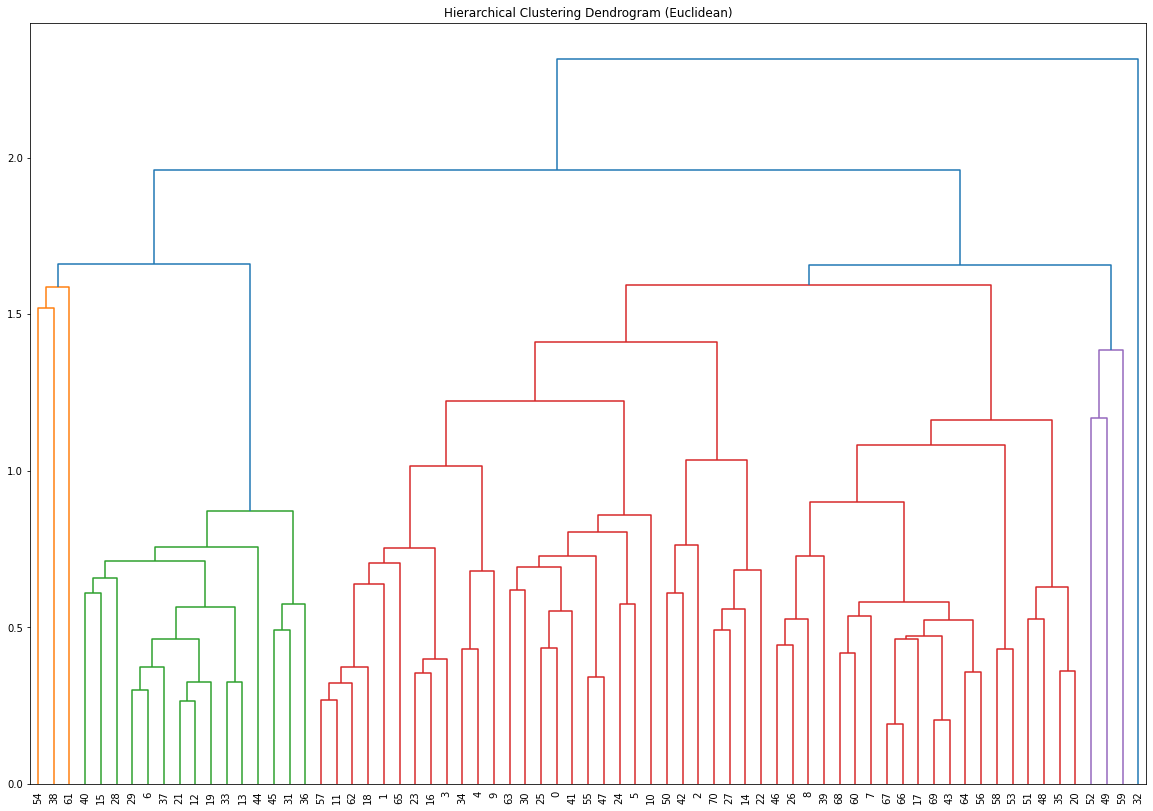

In [837]:
from sklearn.preprocessing import normalize
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
normalized_representative_vectors = normalize(representative_vectors, axis=1, norm='l2')
dist_matrix_euclidean = pdist(representative_vectors,metric="euclidean")
dist_matrix_cosine = pdist(representative_vectors,metric="cosine")

linked_euclidean = linkage(dist_matrix_euclidean, 'ward')
linked_cosine = linkage(dist_matrix_cosine, 'ward')

# Plot the dendrograms
plt.figure(figsize=(20, 14))
plt.title("Hierarchical Clustering Dendrogram (Euclidean)")
dendrogram(linked_euclidean, orientation='top', distance_sort='descending', show_leaf_counts=True)
# make the x axis labels larger
plt.xticks(fontsize=10)
plt.show()


In [814]:
len(index_dict.keys())

37

In [949]:
from itertools import combinations
pair_list = []
for key, values in index_dict.items():
    pairs = combinations(values, 2)  # all unordered pairs
    pair_list.extend(pair for pair in pairs)

print(len(pair_list))

45


In [738]:
semantic_map.instance_id_to_name[47]

'door'

In [ ]:
index_dict = {}
for idx, obj_id, _ in final_labels:
    if obj_id not in index_dict.keys():
        index_dict[obj_id] = [idx]
    else:
        index_dict[obj_id].append(idx)


[49, 54, 59, 66, 67]


In [1284]:
for idx,labels in enumerate(short_grouped_set):
    output_folder = f"./outputs/{idx}"
    if not os.path.exists(output_folder):
        os.mkdir(output_folder)
    for img_id,mask_id in labels: 
        rgb_img = semantic_map.rgb_observations[img_id].copy()
        mask = semantic_map.refined_prediction_masks[img_id][mask_id]
        kernel = np.ones((3, 3), np.uint8)
        dilated_mask = cv2.dilate(mask,kernel,iterations=1)
        edges = dilated_mask - mask
        rgb_img[edges==1] = [255,0,0]
        res = cv2.cvtColor(rgb_img,cv2.COLOR_RGB2BGR)
        try:
            image_path = os.path.join(output_folder,f"{img_id}_{mask_id}_{semantic_map.gt_pred_correspondences[img_id][mask_id][0]}.png")
        except:
            image_path = os.path.join(output_folder,f"{img_id}_{mask_id}.png")
        cv2.imwrite(image_path,res)

In [ ]:
semantic_map.gt_pred_correspondences

In [ ]:
counter = 0
for node0,mask0,node1,mask1 in object_matches:
    rgb_img0 = semantic_map.rgb_observations[node0].copy()
    mask = semantic_map.refined_prediction_masks[node0][mask0]
    kernel = np.ones((3, 3), np.uint8)
    dilated_mask = cv2.dilate(mask,kernel,iterations=1)
    edges = dilated_mask - mask
    rgb_img0[edges==1] = [255,0,0]
    rgb_img1 = semantic_map.rgb_observations[node1].copy()
    mask = semantic_map.refined_prediction_masks[node1][mask1]
    kernel = np.ones((3, 3), np.uint8)
    dilated_mask = cv2.dilate(mask,kernel,iterations=1)
    edges = dilated_mask - mask
    rgb_img1[edges==1] = [255,0,0]
    res = np.vstack((rgb_img0,rgb_img1))
    plt.imshow(res)
    plt.show()
    counter+=1
    if counter>10:
        break
    

In [1169]:
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt

def find_disconnected_subgraphs(edge_list):
    # Build graph as an adjacency list
    graph = defaultdict(list)
    nodes = set()
    
    for src, dest in edge_list:
        graph[src].append(dest)
        graph[dest].append(src)  # Assuming an undirected graph
        nodes.update([src, dest])
    
    visited = set()
    subgraphs = []
    
    def dfs(node, subgraph):
        stack = [node]
        while stack:
            current = stack.pop()
            if current not in visited:
                visited.add(current)
                subgraph.append(current)
                stack.extend(graph[current])
    
    for node in nodes:
        if node not in visited:
            subgraph = []
            dfs(node, subgraph)
            subgraphs.append(subgraph)
    
    return subgraphs

In [1175]:
def visualize_subgraphs(edge_list):
    G = nx.Graph()
    G.add_edges_from(edge_list)
    
    # Get disconnected subgraphs
    subgraphs = list(nx.connected_components(G))

    return subgraphs

In [1199]:
import community

def cut_subgraph(edge_list):
    G = nx.Graph()
    G.add_edges_from(edge_list)
    print(len(G.nodes))
    partition = community.best_partition(G)

    communities = defaultdict(list)
    for node, comm_id in partition.items():
        communities[comm_id].append(node)

    # Step 5: Create subgraphs from communities
    subgraphs = [G.subgraph(nodes) for nodes in communities.values()]

        # Assign a color to each community
    colors = [partition[n] for n in G.nodes()]

    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color=colors, cmap=plt.cm.Set3)
    plt.title("Louvain Community Detection")
    plt.show()
    
    return subgraphs
    

In [1183]:
!python -m pip install python-louvain
 

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9418 sha256=c589b2c37c16c2642df776c3ca79d2dcbc865c28d39de421873b340013bffa11
  Stored in directory: c:\users\afiyet olsun\appdata\local\pip\cache\wheels\d0\b0\d7\6dd26c3817810fa379088eaeb755a01d9a2a411c37632079d1
Successfully built python-louvain


  DEPRECATION: Building 'python-louvain' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'python-louvain'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [1208]:
edges = []
nodes = []
for node in subgraphs[0]:
    nodes.append(node)
    for match in object_list:
        if node in match:
            edges.append(match)
print(len(nodes))
print(len(edges))

268
5024


In [1209]:
# Create an undirected graph (use DiGraph() for directed)
G = nx.Graph()

# Add nodes and edges
G.add_nodes_from(nodes)
G.add_edges_from(edges)

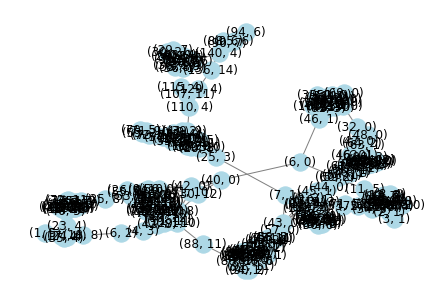

In [1210]:
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray')
plt.show()

In [1211]:
partition = community.best_partition(G)

# Group nodes into subgraphs
from collections import defaultdict
clusters = defaultdict(list)
for node, group in partition.items():
    clusters[group].append(node)

small_subgraphs = [G.subgraph(nodes) for nodes in clusters.values()]

In [1215]:
idx = 13
for i in small_subgraphs:
    output_folder = f"./outputs/{idx}"
    if not os.path.exists(output_folder):
        os.mkdir(output_folder)
    for img_id,mask_id in i.nodes: 
        rgb_img = semantic_map.rgb_observations[img_id].copy()
        mask = semantic_map.refined_prediction_masks[img_id][mask_id]
        kernel = np.ones((3, 3), np.uint8)
        dilated_mask = cv2.dilate(mask,kernel,iterations=1)
        edges = dilated_mask - mask
        rgb_img[edges==1] = [255,0,0]
        res = cv2.cvtColor(rgb_img,cv2.COLOR_RGB2BGR)
        try:
            image_path = os.path.join(output_folder,f"{img_id}_{mask_id}_{semantic_map.gt_pred_correspondences[img_id][mask_id][0]}.png")
        except:
            image_path = os.path.join(output_folder,f"{img_id}_{mask_id}.png")
        cv2.imwrite(image_path,res)
    idx += 1